In [1]:
!pip install -q transformers datasets accelerate sentencepiece evaluate rouge_score


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.5 MB/s eta 0:00:00


In [2]:
from google.colab import drive
from pathlib import Path

drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
DRIVE_ROOT   = Path("/content/drive/MyDrive/do-an-tot-nghiep")
DATA_DIR     = DRIVE_ROOT / "dataset"
ARTIFACT_DIR = DRIVE_ROOT / "artifacts_03"

ARTIFACT_DIR.mkdir(parents=True, exist_ok=True)

DATA_PATH = DATA_DIR / "summarize_data_combined.csv"

BASE_MODEL_NAME = "VietAI/vit5-base"

USE_PREV_MODEL = True
PREV_MODEL_DIR = ARTIFACT_DIR / "best_model_combined"

# Số epoch mỗi phiên
NUM_EPOCHS_PER_RUN = 2

RUN_DIR = ARTIFACT_DIR / "runs_combined"
RUN_DIR.mkdir(parents=True, exist_ok=True)

# Nơi lưu model tốt nhất của phiên hiện tại
BEST_MODEL_DIR = ARTIFACT_DIR / "best_model_combined"
BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)

print("DRIVE_ROOT  :", DRIVE_ROOT)
print("DATA_PATH   :", DATA_PATH, "->", DATA_PATH.exists())
print("ARTIFACT_DIR:", ARTIFACT_DIR)
print("RUN_DIR     :", RUN_DIR)
print("BEST_MODEL_DIR:", BEST_MODEL_DIR)
print("USE_PREV_MODEL:", USE_PREV_MODEL)
print("PREV_MODEL_DIR:", PREV_MODEL_DIR)


DRIVE_ROOT  : /content/drive/MyDrive/do-an-tot-nghiep
DATA_PATH   : /content/drive/MyDrive/do-an-tot-nghiep/dataset/summarize_data_combined.csv -> True
ARTIFACT_DIR: /content/drive/MyDrive/do-an-tot-nghiep/artifacts_03
RUN_DIR     : /content/drive/MyDrive/do-an-tot-nghiep/artifacts_03/runs_combined
BEST_MODEL_DIR: /content/drive/MyDrive/do-an-tot-nghiep/artifacts_03/best_model_combined
USE_PREV_MODEL: True
PREV_MODEL_DIR: /content/drive/MyDrive/do-an-tot-nghiep/artifacts_03/best_model_combined


Load dữ liệu & chia train/val/test

In [4]:
import pandas as pd
from datasets import Dataset, DatasetDict

df = pd.read_csv(DATA_PATH)
print("Số mẫu tổng:", len(df))
print("Các cột:", df.columns.tolist())
df.head()


Số mẫu tổng: 15339
Các cột: ['input_text', 'target_text']


,input_text,target_text
0,"Y án tử hình kẻ sát hại cô gái, bỏ xác vào val...",Thanh Phương Tòa phúc thẩm TAND tối cao tại TP...
1,Carlsen gieo thêm sầu cho Vua cờ Gukesh. Carls...,Carlsen thắng cả 4 ván gặp Gukesh và kỳ thủ số...
2,Tạm đình chỉ công tác hiệu trưởng vì để thực p...,Xuân Ngọc UBND phường Xuân Hương - Đà Lạt (Lâm...
3,Tổng Bí thư thăm lớp học mang tên Chủ tịch Hồ ...,"Tại đây, các học sinh đã trình bày những tiết ..."
4,"Công Phượng chưa hẹn ngày trở lại, Đồng Nai có...","Với Đồng Nai, nếu giành 3 điểm, họ tiếp tục du..."


In [6]:
# Đảm bảo có input_text, target_text
assert "input_text" in df.columns and "target_text" in df.columns

ds = Dataset.from_pandas(df[["input_text", "target_text"]], preserve_index=False)

# Chia 80/10/10
ds_train_val = ds.train_test_split(test_size=0.2, seed=42)
ds_train = ds_train_val["train"]
ds_tmp   = ds_train_val["test"]

ds_val_test = ds_tmp.train_test_split(test_size=0.5, seed=42)
ds_val  = ds_val_test["train"]
ds_test = ds_val_test["test"]

dataset = DatasetDict({
    "train": ds_train,
    "validation": ds_val,
    "test": ds_test,
})

for split in dataset:
    print(f"{split:10s}: {len(dataset[split])} mẫu")


train     : 12271 mẫu
validation: 1534 mẫu
test      : 1534 mẫu


Load tokenizer + model

In [8]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
import torch

MAX_SOURCE_LEN = 1500
MAX_TARGET_LEN = 320

if USE_PREV_MODEL and PREV_MODEL_DIR.exists():
    print("==> Load model từ phiên trước:", PREV_MODEL_DIR)
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(PREV_MODEL_DIR)
else:
    print("==> Load model gốc:", BASE_MODEL_NAME)
    tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)
    model = AutoModelForSeq2SeqLM.from_pretrained(BASE_MODEL_NAME)

model.to("cuda")
print("Model trên device:", next(model.parameters()).device)


==> Load model từ phiên trước: /content/drive/MyDrive/do-an-tot-nghiep/artifacts_03/best_model_combined
Model trên device: cuda:0


Tokenize



In [ ]:
def preprocess_function(batch):
    inputs  = batch["input_text"]
    targets = batch["target_text"]

    model_inputs = tokenizer(
        inputs,
        max_length=MAX_SOURCE_LEN,
        truncation=True,
        padding=False,
    )

    labels = tokenizer(
        text_target=targets,
        max_length=MAX_TARGET_LEN,
        truncation=True,
        padding=False,
    )

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_ds = dataset.map(
    preprocess_function,
    batched=True,
    remove_columns=dataset["train"].column_names,
    desc="Tokenizing dataset",
)

for split in tokenized_ds:
    print(split, "keys:", tokenized_ds[split][0].keys())


Tokenizing dataset:   0%|          | 0/12271 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/1534 [00:00<?, ? examples/s]

Tokenizing dataset:   0%|          | 0/1534 [00:00<?, ? examples/s]

train keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
validation keys: dict_keys(['input_ids', 'attention_mask', 'labels'])
test keys: dict_keys(['input_ids', 'attention_mask', 'labels'])


Kiểm tra Truncation

In [ ]:
input_truncated = 0
target_truncated = 0

for split in ["train", "validation", "test"]:
    for sample in tokenized_ds[split]:
        if len(sample["input_ids"]) == MAX_SOURCE_LEN:
            input_truncated += 1
        if len(sample["labels"]) == MAX_TARGET_LEN:
            target_truncated += 1

total = sum(len(tokenized_ds[s]) for s in ["train", "validation", "test"])
print(f"Input truncated : {input_truncated}/{total} ({input_truncated/total*100:.1f}%)")
print(f"Target truncated: {target_truncated}/{total} ({target_truncated/total*100:.1f}%)")


Input truncated : 555/15339 (3.6%)
Target truncated: 84/15339 (0.5%)


Data collator

In [ ]:
from transformers import DataCollatorForSeq2Seq

data_collator = DataCollatorForSeq2Seq(
    tokenizer=tokenizer,
    model=model,
    label_pad_token_id=-100,
    pad_to_multiple_of=8,
)


TrainingArguments + Trainer

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=str(RUN_DIR),

    eval_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="steps",
    logging_steps=100,
    save_total_limit=2,

    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    gradient_accumulation_steps=4,
    num_train_epochs=NUM_EPOCHS_PER_RUN,

    predict_with_generate=False,
    fp16=True,
    report_to="none",

    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,

    # Hyperparam để tránh overfit sớm
    learning_rate=2e-5,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    weight_decay=0.01,
    label_smoothing_factor=0.1,
)


In [ ]:
from transformers import Seq2SeqTrainer, EarlyStoppingCallback

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_ds["train"],
    eval_dataset=tokenized_ds["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
)

trainer.train()


/tmp/ipython-input-1773332177.py:3: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Epoch,Training Loss,Validation Loss
1,1.878800,1.803298
2,1.800700,1.783981


There were missing keys in the checkpoint model loaded: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight'].


TrainOutput(global_step=3068, training_loss=1.9514747828517154, metrics={'train_runtime': 5086.9327, 'train_samples_per_second': 4.825, 'train_steps_per_second': 0.603, 'total_flos': 2.629069124861952e+16, 'train_loss': 1.9514747828517154, 'epoch': 2.0})

Lưu model tốt nhất

In [ ]:
BEST_MODEL_DIR.mkdir(parents=True, exist_ok=True)
trainer.save_model(str(BEST_MODEL_DIR))
tokenizer.save_pretrained(str(BEST_MODEL_DIR))

print("Đã lưu model tốt nhất của phiên vào:", BEST_MODEL_DIR)


Đã lưu model tốt nhất của phiên vào: /content/drive/MyDrive/do-an-tot-nghiep/artifacts_03/best_model_combined


Visualize loss

log1 shape: (32, 9)
log2 shape: (49, 9)


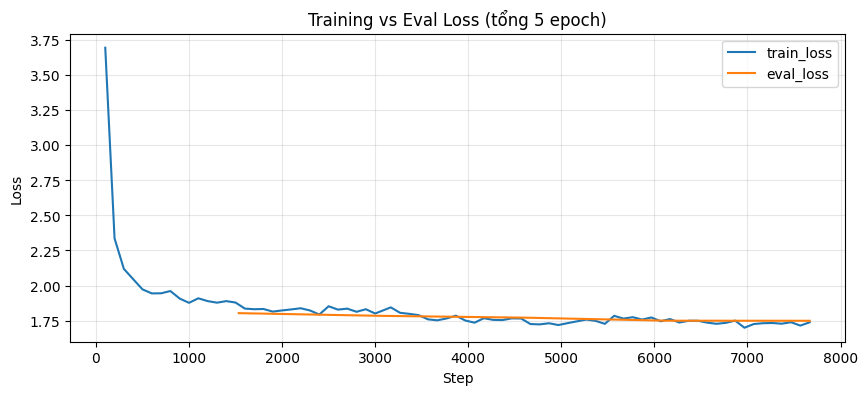

In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path

# Thư mục runs
DRIVE_ROOT   = Path("/content/drive/MyDrive/do-an-tot-nghiep")
RUNS_DIR     = DRIVE_ROOT / "artifacts_03" / "runs_combined"

# ĐƯỜNG DẪN 2 CHECKPOINT
CKPT_RUN1 = RUNS_DIR / "checkpoint-3068"
CKPT_RUN2 = RUNS_DIR / "checkpoint-4602"

def load_log_from_ckpt(ckpt_dir: Path) -> pd.DataFrame:
    state_path = ckpt_dir / "trainer_state.json"
    with open(state_path, "r", encoding="utf-8") as f:
        state = json.load(f)
    return pd.DataFrame(state["log_history"])

log1 = load_log_from_ckpt(CKPT_RUN1)
log2 = load_log_from_ckpt(CKPT_RUN2)

print("log1 shape:", log1.shape)
print("log2 shape:", log2.shape)

# Để step của run2 nối tiếp run1
offset = log1["step"].max()
log2["step"] = log2["step"] + offset

# Ghép 2 log
log_all = pd.concat([log1, log2], ignore_index=True)

# Tách train/eval loss
train_logs = log_all[log_all["loss"].notna()][["step", "loss"]]
eval_logs  = log_all[log_all["eval_loss"].notna()][["step", "eval_loss"]]

plt.figure(figsize=(10, 4))
plt.plot(train_logs["step"], train_logs["loss"], label="train_loss")
plt.plot(eval_logs["step"],  eval_logs["eval_loss"], label="eval_loss")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("Training vs Eval Loss (tổng 5 epoch)")
plt.legend()
plt.grid(alpha=0.3)
plt.show()


In [9]:
import evaluate
import numpy as np
import torch
from tqdm.auto import tqdm

# Nếu bạn đang mở lại notebook mới ở phiên khác:
# 1) mount drive + set DRIVE_ROOT, DATA_DIR, ARTIFACT_DIR, DATA_PATH, BEST_MODEL_DIR
# 2) load df + dataset giống các cell trước
# 3) load model:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
tokenizer = AutoTokenizer.from_pretrained("VietAI/vit5-base")
model = AutoModelForSeq2SeqLM.from_pretrained(BEST_MODEL_DIR).to("cuda")

rouge = evaluate.load("rouge")

test_df = dataset["test"].to_pandas()

MAX_EVAL_SAMPLES = 100   # đủ để so chất lượng, tránh OOM
n = min(MAX_EVAL_SAMPLES, len(test_df))
print(f"Đánh giá ROUGE trên {n} mẫu test.")

model.eval()
preds = []
refs  = []

@torch.no_grad()
def generate_summary(text: str,
                     max_new_tokens: int = 220,
                     num_beams: int = 5):
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SOURCE_LEN,   # 1500
    ).to("cuda")

    with torch.amp.autocast("cuda"):
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            length_penalty=0.8,
            no_repeat_ngram_size=3,
            repetition_penalty=1.05,
        )

    return tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()

for i in tqdm(range(n)):
    row = test_df.iloc[i]
    src_text = str(row["input_text"])
    ref_text = str(row["target_text"]).strip()

    refs.append(ref_text)
    pred_text = generate_summary(src_text)
    preds.append(pred_text)

metrics = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
test_metrics = {f"test_{k}": round(v * 100, 2) for k, v in metrics.items()}
test_metrics


Đánh giá ROUGE trên 100 mẫu test.


  0%|          | 0/100 [00:00<?, ?it/s]

{'test_rouge1': np.float64(81.09),
 'test_rouge2': np.float64(59.25),
 'test_rougeL': np.float64(56.62),
 'test_rougeLsum': np.float64(56.55)}

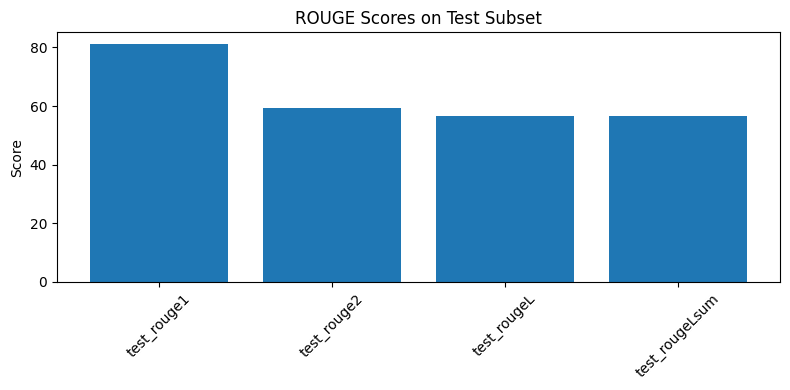

In [10]:
import matplotlib.pyplot as plt

test_rouge = {k: v for k, v in test_metrics.items() if "rouge" in k.lower()}
plt.figure(figsize=(8, 4))
plt.bar(test_rouge.keys(), test_rouge.values())
plt.xticks(rotation=45)
plt.ylabel("Score")
plt.title("ROUGE Scores on Test Subset")
plt.tight_layout()
plt.show()


Test

In [ ]:
import re
import torch

@torch.inference_mode()
def summarize_text(
    text: str,
    max_new_tokens: int = 160,
    num_beams: int = 4,
) -> str:
    # Làm sạch input nhẹ
    text = text.replace("\r\n", "\n")
    text = re.sub(r"\n+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # Tokenize & đưa lên GPU
    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=MAX_SOURCE_LEN,
    ).to("cuda")

    with torch.amp.autocast("cuda"):
        output_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            num_beams=num_beams,
            length_penalty=1.0,
            no_repeat_ngram_size=4,
            repetition_penalty=1.1,
        )

    summary = tokenizer.decode(output_ids[0], skip_special_tokens=True).strip()
    return summary


In [ ]:
news_text = """
72 người chết do mưa lũ, Đăk Lăk còn 4 xã, phường ngập nặng

Số người chết do mưa lũ ở 6 tỉnh tiếp tục tăng; riêng Đăk Lăk thêm 13 người, lên 44, khi nhiều khu vực ngập sâu được tiếp cận, còn bốn xã, phường vẫn ngập nặng.

Chiều 22/11, Cục Quản lý đê điều và Phòng chống thiên tai cho biết, tính đến 17h, mưa lũ ở Nam Trung Bộ đã làm 72 người chết, tăng 17 người so với sáng nay. Đăk Lăk là địa bàn thiệt hại nặng nhất với 44 người chết, Khánh Hòa 14, Lâm Đồng và Gia Lai mỗi năm 5 người, Huế và Đà Nẵng mỗi nơi hai người.

Hiện còn 13 người mất tích (không thay đổi so với sáng nay), trong đó Đăk Lăk 8 người, Đà Nẵng, Khánh Hòa mỗi nơi hai người và Quảng Trị một người.

Hai hôm nay, mưa ở Nam Trung Bộ và Tây Nguyên cơ bản đã giảm nên lũ trên các sông đang rút. Lúc 16h, mực nước lũ sông Ba tại Củng Sơn (Đăk Lăk) dưới báo động hai 0,87 m; sông Krông Ana tại Giang Sơn trên báo động ba 1,41 m.

Lũ sông Sêrêpôk tại Bản Đôn trên báo động ba 3,86 m. Lũ sông Dinh tại trạm Ninh Hòa (Khánh Hòa) dưới báo động ba 0,15 m. Lũ sông Đồng Nai tại Tà Lài (Đồng Nai) trên báo động hai 0,16 m.

Nước rút giúp Gia Lai không còn hộ bị ngập. Tại Khánh Hòa chỉ còn 87 hộ với hơn 360 người ở hai xã Diên Điền và Hòa Trí ngập. Lâm Đồng còn ngập ở 127 hộ ở xã Nam Đà và Cát Tiên.

Nghiêm trọng nhất đang là Đăk Lăk khi bốn đơn vị gồm phường Hòa Xuân, Đông Hòa, xã Hòa Thịnh và Hòa Mỹ vẫn còn nhiều khu dân cư ngập sâu. Tỉnh này ước tính lúc cao điểm có khoảng 150.000 nhà bị ngập.

Mưa lũ đã làm gần 1,2 triệu hộ mất điện, hiện đã khôi phục được hơn 920.000 hộ. 162.000 hộ ở Đăk Lăk, 75.000 hộ ở Khánh Hòa và 20.000 hộ ở Gia Lai vẫn đang mất điện.

Hiện còn 75/201 xã phường bị mất kết nối mạng truyền số liệu chuyên dùng cấp hai từ tỉnh đến xã do mất điện. Trong đó, Đăk Lăk 31 đơn vị, Gia Lai 26 và Khánh Hòa 18. Cùng với đó, 552 trạm BTS bị mất kết nối, chủ yếu ở Đăk Lăk và Khánh Hòa.

Hôm nay, quốc lộ 1 đã thông xe toàn tuyến. Tuy nhiên, còn 13 vị trí tại các tuyến quốc lộ 4E, 27C, 20, 28 và đường Trường Sơn Đông qua Quảng Ngãi vẫn bị chia cắt do sạt lở. Ngành đường sắt vẫn đang cấm 6 đoạn gồm Xuân Sơn Nam - Chí Thạnh; Đông Tác - Phú Hiệp; Phú Hiệp - Hảo Sơn; Hảo Sơn - Đại Lãnh; Nha Trang - Cây Cầy; Cây Cầy - Hòa Tân.

Cơ quan chức năng ước tính thiệt hại kinh tế do mưa lũ gần 9.000 tỷ đồng, trong đó riêng Đăk Lăk chưa tính tài sản hộ dân là 5.300 tỷ, gồm 2.000 tỷ thủy sản, 1.000 tỷ cơ sở hạ tầng, hơn 800 tỷ gia súc, gia cầm và 1.500 tỷ cây trồng.

Cục Quản lý đê điều và Phòng chống thiên tai cho biết, Đăk Lăk đang cần 2.000 tấn lương thực, 3 tấn hóa chất Cloramine B, 1.000 lít hóa chất xử lý nguồn nước và môi trường; 1.000 túi sơ cấp cứu, 2.000 túi thuốc y tế và 5.000 túi an sinh, 30.000 lít hóa chất để khử trùng; hỗ trợ giống cây trồng, vật nuôi để khôi phục sản xuất.

Gia Lai cần 2.000 tấn gạo, 3 tấn hóa chất Cloramine B, 100.000 viên Aquatabs.

Dự báo từ chiều tối nay đến 24/11, Huế, Đà Nẵng và phía đông Quảng Ngãi mưa 60-120 mm, cục bộ trên 250 mm; phía đông Gia Lai, Đăk Lăk và bắc Khánh Hòa mưa 40-80 mm, cục bộ trên 150 mm.

24 giờ tới, lũ trên sông Krông Ana xuống dưới báo động ba, sông Đồng Nai và sông Dinh (Khánh Hòa) xuống dưới báo động hai, còn sông Sêrêpôk tại Bản Đôn dao động trên báo động ba.
"""

print(summarize_text(news_text))


NameError: name 'tokenizer' is not defined